# 0. Description

This kernel trains a __CNN__ model built in Keras on the __MNIST__ dataset. The model follows a classic pattern of LeNet-5 and includes 5 layers (counting only layers with weights). The greatness of Keras in how fast you can implement you ideas, test them and move on. But on the other hand, a simple Keras API hides many details of how the system actually works. Therefore, I am also going to implement a similar CNN model "from scratch" in Python code and Numpy in a separate kernel as part of the "Under the Hood" series of kernels.

LeNet-5 is a simple CNN and runs pretty fast 50 epochs in the GPU mode to get 99.2% validation accuracy without data augmentation. 
Adding data augmentation to prevent overfitting is likely to further improve accuracy of the model.
 
Any feedback or ideas are welcome.

In [16]:
# Load necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # to convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

## 1. MNIST DATA

In [17]:
# Load datasets
train, test = pd.read_csv("../input/train.csv"), pd.read_csv("../input/test.csv")

In [18]:
# Review data
print(f'train data shape = {train.shape}', '/', f'test data shape = {test.shape}')
train.head()

train data shape = (42000, 785) / test data shape = (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# let's check the count of different labels in the dataset (~balanced)
train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [20]:
# Numpy representation of the train and test data:
train_pixels, test_pixels = train.iloc[:,1:].values.astype('float32'), test.values.astype('float32') # all pixel values
train_labels = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
train_labels = train_labels.reshape(-1, 1) # ensure proper shape of the array

print(f'train_pixels shape = {train_pixels.shape}')
print(f'test_pixels shape = {test_pixels.shape}')
print(f'train_labels shape = {train_labels.shape}')

train_pixels shape = (42000, 784)
test_pixels shape = (28000, 784)
train_labels shape = (42000, 1)


In [21]:
# Reshape input data to fit Keras model (height=28px, width=28px, channels=1):
train_pixels, test_pixels = train_pixels.reshape(-1, 28, 28, 1), test_pixels.reshape(-1, 28, 28, 1)
print(f'train_pixels shape = {train_pixels.shape}')
print(f'test_pixels shape = {test_pixels.shape}')

train_pixels shape = (42000, 28, 28, 1)
test_pixels shape = (28000, 28, 28, 1)


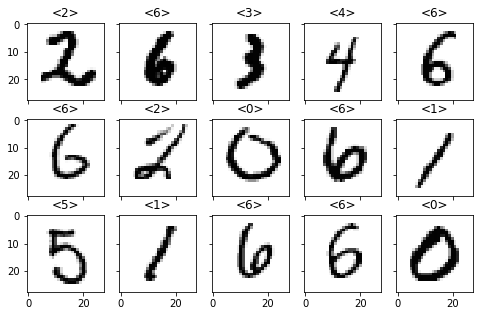

In [22]:
# Visualize some images from the dataset:
nrows, ncols = 3, 5  # number of rows and colums in subplots
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,5))
for row in range(nrows):
    for col in range(ncols):
        i = np.random.randint(0, 30000)  # pick up arbitrary examples
        ax[row, col].imshow(train_pixels[i,:,:,0], cmap='Greys')
        ax[row, col].set_title(f'<{train.label[i]}>');

In [23]:
# Input data are greyscale pixels of intensity [0:255]. Let's normalize to [0:1]:
train_pixels, test_pixels = train_pixels / 255.0, test_pixels / 255.0

In [24]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
train_labels = to_categorical(train_labels, num_classes = 10)
print(f'train_labels shape = {train_labels.shape}')
train_labels

train_labels shape = (42000, 10)


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [25]:
# Split training and validation set for the fitting
train_pixels, val_pixels, train_labels, val_labels = train_test_split(train_pixels, train_labels, test_size = 0.1, random_state=None)

train_pixels.shape, train_labels.shape, val_pixels.shape, val_labels.shape, test_pixels.shape

((37800, 28, 28, 1),
 (37800, 10),
 (4200, 28, 28, 1),
 (4200, 10),
 (28000, 28, 28, 1))

In [26]:
# let's fix the important numbers for further modeling:
m_train = train_pixels.shape[0]   # number of examples in the training set
m_val = val_pixels.shape[0]       # number of examples in the validation set
m_test = test_pixels.shape[0]     # number of examples in the test set
n_x = test.shape[1]               # input size, number of pixels in the image
n_y = train_labels.shape[1]       # output size, number of label classes
print(f" m_train = {m_train} / m_val = {m_val} / m_test = {m_test} / n_x = {n_x} / n_y = {n_y}")

 m_train = 37800 / m_val = 4200 / m_test = 28000 / n_x = 784 / n_y = 10


In [27]:
# Let's also define ImageDataGenerator for data augmentation to prevent overfitting:
datagen = ImageDataGenerator(
        rotation_range = 10,  # randomly rotate images in the range [0-180 degrees]
        zoom_range = 0.1, # randomly zoom image: [lower, upper] = [1-zoom_range, 1+zoom_range]
        shear_range = 0.1, # random distortion
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1)  # randomly shift images vertically (fraction of total height)


## 2. CNN model with Keras

 __The architecture follows a classic pattern of LeNet5:__  
 
 INPUT -> (CONV1  + POOL1) -> (CONV2  + POOL2) -> FLATTEN + FC3 + FC4 -> OUTPUT/SOFTMAX

In [28]:
# create an instance of a neural network:
model = Sequential()
# Layer 1:
model.add(Conv2D(filters=6, kernel_size=5, padding='Same', 
                 activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.25))
# Layer 2:
model.add(Conv2D(filters=16, kernel_size=5, padding='Valid', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.25))
# Layer 3:
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.25))
# Layer 4:
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.25))
# Output layer 5:
model.add(Dense(10, activation='softmax'))

# Compile the model w/Adam optimizer:
model.compile(optimizer=Adam(lr=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-7)

# Fit the model with the original dataset --> val_accuracy 0.992:
History = model.fit(train_pixels, train_labels, epochs=50,
                    validation_data=(val_pixels, val_labels),
                    callbacks=[lr_decay], verbose=1)
"""

# Fit the model on batches with real-time data augmentation:
History = model.fit_generator(datagen.flow(train_pixels, train_labels), epochs=40,
                              steps_per_epoch=m_train/32, callbacks=[lr_decay], verbose=1)
"""

# Evaluate the model:
train_loss, train_acc = model.evaluate(train_pixels, train_labels)
val_loss, val_acc = model.evaluate(val_pixels, val_labels)
print(f'model: train accuracy = {round(train_acc * 100, 4)}%')
print(f'model: val accuracy = {round(val_acc * 100, 4)}%')
print(f'model: val error = {round((1 - val_acc) * m_val)} examples')


Train on 37800 samples, validate on 4200 samples
Epoch 1/50
37800/37800 [==============================] - 10s 268us/step - loss: 0.4440 - acc: 0.8584 - val_loss: 0.1058 - val_acc: 0.9629
Epoch 2/50
37800/37800 [==============================] - 9s 251us/step - loss: 0.1578 - acc: 0.9527 - val_loss: 0.0737 - val_acc: 0.9771
Epoch 3/50
37800/37800 [==============================] - 9s 249us/step - loss: 0.1241 - acc: 0.9621 - val_loss: 0.0579 - val_acc: 0.9836
Epoch 4/50
37800/37800 [==============================] - 9s 249us/step - loss: 0.1081 - acc: 0.9680 - val_loss: 0.0513 - val_acc: 0.9852
Epoch 5/50
37800/37800 [==============================] - 10s 254us/step - loss: 0.0941 - acc: 0.9726 - val_loss: 0.0441 - val_acc: 0.9852
Epoch 6/50
37800/37800 [==============================] - 10s 255us/step - loss: 0.0870 - acc: 0.9740 - val_loss: 0.0388 - val_acc: 0.9879
Epoch 7/50
37800/37800 [==============================] - 9s 251us/step - loss: 0.0802 - acc: 0.9762 - val_loss: 0.0499 

37800/37800 [==============================] - 9s 245us/step - loss: 0.0334 - acc: 0.9892 - val_loss: 0.0256 - val_acc: 0.9921

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 49/50
37800/37800 [==============================] - 9s 245us/step - loss: 0.0346 - acc: 0.9888 - val_loss: 0.0256 - val_acc: 0.9921

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 50/50
37800/37800 [==============================] - 9s 244us/step - loss: 0.0360 - acc: 0.9888 - val_loss: 0.0256 - val_acc: 0.9921

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1e-07.
4200/4200 [==============================] - 0s 64us/step
model: train accuracy = 99.7804%
model: val accuracy = 99.2143%
model: val error = 33.0 examples


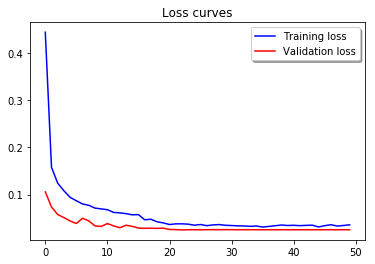

In [29]:
# Plot the loss and accuracy curves over epochs:
fig, ax = plt.subplots()
ax.plot(History.history['loss'], color='b', label='Training loss')
ax.plot(History.history['val_loss'], color='r', label='Validation loss')
ax.set_title("Loss curves")
legend = ax.legend(loc='best', shadow=True)

# -1. Submitting Predictions to Kaggle

In [30]:
predictions = model.predict_classes(test_pixels)

submission = pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                           "Label"  : predictions})
submission.to_csv("submission.csv", index=False, header=True)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
